# Foursquare Data Clustering 

Легенда следующая:

Международное круизное агентство Carnival Cruise Line решило запустить рекламную кампанию с использованием баннеров. Для того, чтобы определить возможную выгоду от этих баннеров, на первом этапе будет размещено только 20 баннеров по всему миру.

Круизное агентство имеет 6 офисов по всему миру. Лучшее место для размещения баннеров (с точки зрения агентства) - это недалеко от офисов агенства. Эти места также должны быть популярны среди туристов.

Для определения оптимальных мест используется [база данных Foursquare](https://archive.org/details/201309_foursquare_dataset_umn).

Для определения основных туристических центров необходимо выполнить кластеризацию координат. Алгоритм кластеризации должен иметь возможность ограничения кластера и способность показывать точные результаты без установки количества кластеров.

### Чистка данных

In [1]:
import numpy as np
import pandas as pd

import warnings
warnings.filterwarnings('ignore')

from sklearn.cluster import MeanShift
from geopy.distance import geodesic
import matplotlib.pyplot as plt
import cartopy.crs as ccrs

In [2]:
# чтение данных
data = pd.read_csv('checkins.dat', sep = '|', skipinitialspace = True)
data.columns

Index(['id    ', 'user_id ', 'venue_id ', 'latitude      ', 'longitude     ',
       'created_at      '],
      dtype='object')

In [3]:
# изменение имен признаков
mapping = {'id    ' : 'id',
           'user_id ' : 'user_id',
           'venue_id ' : 'venue_id',
           'latitude      ' : 'latitude',
           'longitude     ' : 'longitude',
           'created_at      ' : 'created_at'}

data.columns = data.columns.map(mapping)

In [4]:
# оставляем только ненулевые значения широты и долготы
data = data[data['latitude'].notnull() & data['longitude'].notnull()][['latitude', 'longitude']]

In [5]:
# координаты основных офисов
offices = {'Los Angeles' : [33.751277, -118.188740],
           'Miami' : [25.867736, -80.324116],
           'London' : [51.503016, -0.075479],
           'Amsterdam' : [52.378894, 4.885084],
           'Beijing' : [39.366487, 117.036146],
           'Sydney' : [-33.868457, 151.205134]}

### Кластеризация координат с помощью алгоритма `MeanShift` библиотеки `scikit-learn`

Используется bandwidth, равный 0.1, что равно 5-10 км на средних широтах.

In [6]:
%%time

clustering = MeanShift(bandwidth = .1, n_jobs = -1)
clustering.fit(data)

Wall time: 19min 28s


MeanShift(bandwidth=0.1, n_jobs=-1)

In [7]:
# центры кластеров
cl_cntr = clustering.cluster_centers_
cl_cntr.shape[0]

5536

В результате получаем 5536 кластеров.

In [8]:
clusters = pd.Series(clustering.labels_)

# 20 крупных кластеров
large_clusters_idx = clusters.value_counts()[:20].index.tolist()

In [9]:
# выведем количество объектов в кадом кластере в убывающем порядке
clusters.value_counts()

0       56187
2       15282
4       10942
1       10895
3        9175
        ...  
5341        1
5425        1
4466        1
4210        1
5503        1
Length: 5536, dtype: int64

In [10]:
# координаты крупнейшего кластера
cl_cntr[0]

array([ 40.71748459, -73.98935883])

Крупнейший кластер (56,187 элементов) - Нью-Йорк.

Удаляем кластеры с количеством элементов меньше 15.

In [11]:
# количество элементов в каждом кластере в возрастающем порядке
c = clusters.value_counts().values 

# индексы кластеров, с количеством элементов меньше 15
cl_idx = clusters.value_counts().loc[c > 15].index.tolist() 

# количество оставшихся кластеров
len(cl_idx) 

1304

In [12]:
centers = {}
for idx in cl_idx:
    centers[idx] = cl_cntr[idx]

### Подсчет дистанций между центрами кластеров и офисами с помощью метода `distance.geodesic` библиотеки `geopy`

In [13]:
off_lat, off_lon, of, ce, di, lon, lat = [], [], [], [], [], [], []

for office in offices:
    off_lat.append(offices[office][0]) 
    off_lon.append(offices[office][1])
    for center in centers:
        of.append(office)
        ce.append(center)
        di.append(geodesic(offices[office], centers[center]).km)
        lat.append(centers[center][0])
        lon.append(centers[center][1])

In [14]:
# создаем датафрейм
data = pd.DataFrame({'office':of, 'center':ce, 'distance':di, 'longitude':lon, 'latitude':lat})

In [15]:
# выводим 20 ближайших к офисам центров
top_20 = data.sort_values('distance').reset_index(drop = True).head(20)
top_20

,office,center,distance,longitude,latitude
0,Sydney,251,0.313379,151.207082,-33.866146
1,Amsterdam,319,0.864453,4.892268,52.372489
2,Miami,317,2.711792,-80.311245,25.846206
3,London,55,3.585284,-0.127113,51.503055
4,Los Angeles,48,7.823291,-118.144334,33.811275
5,Miami,24,14.115340,-80.215128,25.787086
6,London,849,16.366937,-0.308323,51.480366
7,Miami,98,19.297080,-80.205598,26.005052
8,Los Angeles,79,20.092696,-118.062259,33.898488
9,London,964,20.107314,-0.321786,51.598314


В этих местах можно установить баннеры анества. Однако, в топ-20 ближайших к офисам центров нет центра, близкого к Пекину.

### Отображаем офисы и ближайшие к ним центры с помощью библиотеки `cartopy`

In [16]:
# координаты 20 крупнейших центров
large_lat, large_lon = [], []
for i in large_clusters_idx:
    large_lat.append(data[data.center == i]['latitude'])
    large_lon.append(data[data.center == i]['longitude'])

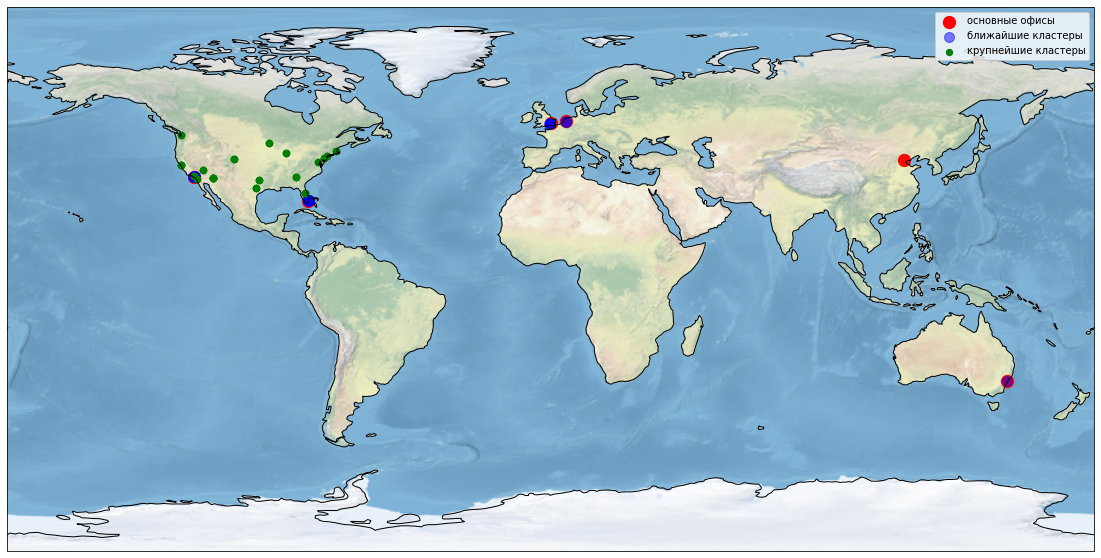

In [17]:
fig = plt.figure(figsize = (20,10))
ax = fig.add_subplot(1, 1, 1, projection=ccrs.PlateCarree())
ax.scatter(off_lon, off_lat, color = 'red', s = 150, label = 'основные офисы')
ax.scatter(top_20.longitude, top_20.latitude, color = 'blue', alpha = 0.5, s = 100, label = 'ближайшие кластеры')

ax.scatter(large_lon, large_lat, color = 'green', s = 40, label = 'крупнейшие кластеры')
ax.coastlines()
ax.stock_img()
plt.legend()
plt.show()

Крупнейшие кластеры располагаются близко к основным офисам агенства (за исключением Пекина). 20 крупнейших кластеров находятся в США.

### Подсчет количества центров из топ-20 крупнейших

In [18]:
data.sort_values('distance').reset_index(drop = True).head(20)['office'].value_counts()

Los Angeles    7
Miami          6
London         4
Amsterdam      2
Sydney         1
Name: office, dtype: int64

### Определение центра ближайшего к Пекину

In [19]:
data[data.office == 'Beijing'].sort_values('distance')

,office,center,distance,longitude,latitude
5643,Beijing,427,80.483274,116.407413,39.904214
6114,Beijing,901,870.220179,126.705206,37.456256
5501,Beijing,285,889.890144,126.978281,37.566110
5649,Beijing,437,988.439781,121.473704,31.230393
6151,Beijing,941,1641.320308,121.550757,25.065852
...,...,...,...,...,...
6134,Beijing,927,18524.837246,-51.228735,-30.027704
6466,Beijing,1245,18969.491010,-71.616452,-33.050462
5636,Beijing,421,19066.782037,-70.570008,-33.425197
6447,Beijing,1247,19343.457040,-58.510679,-34.524128


# Выводы

В результате определен топ-20 оптимальных локаций. Наибольшее количество баннеров можно разместить в Лос-Анджелесе и Майами (7 и 6 соответственно); остальные 7 баннеров можно установить в Амстердаме (3 баннера), Лондоне (2 баннера), Сиднее и Пекине (по 1 баннеру в каждом городе).